In [8]:
# Full script to perform regression using Decision Tree, SVM, and Random Forest
# on the combined dataset and generate all relevant evaluation plots

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import os
import joblib

# Load enriched combined dataset
df = pd.read_csv("../result/time-series-data/t2_combined_enriched.csv")

# Define features and targets
input_features = [
    "latency_p99_ms", "bandwidth_per_request", "outbond_bandwidth",
    "inbond_bandwidth", "envoy_mem_bytes", "latency_spread",
    "rps_user", "memory_per_request"
]
target_columns = ["http2MaxRequests", "http1MaxPendingRequests", "timeout_sec"]

X = df[input_features].fillna(0)
Y = df[target_columns].fillna(0)

# Split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [9]:
# Function to evaluate model

def evaluate_model(model_class, model_name):
    dump_dir = "../model"
    os.makedirs(dump_dir, exist_ok=True)
    results = {}
    for col in Y_train.columns:
        model = model_class()
        model.fit(X_train, Y_train[col])
        preds = model.predict(X_test)
        r2 = r2_score(Y_test[col], preds)
        rmse = mean_squared_error(Y_test[col], preds)

        model_path = os.path.join(dump_dir, f"{model_name}_{col}.pkl")
        joblib.dump(model, model_path)
        results[col] = {"Model": model_name, "R2": r2, "RMSE": rmse}
    return results

In [10]:
# Run evaluations
results_dt = evaluate_model(DecisionTreeRegressor, "Decision Tree")
results_rf = evaluate_model(RandomForestRegressor, "Random Forest")
results_svm = evaluate_model(SVR, "Support Vector Machine")

# Combine results for plotting
all_results = []
for model_result in [results_dt, results_rf, results_svm]:
    for config, metrics in model_result.items():
        all_results.append({
            "Model": metrics["Model"],
            "Configuration": config,
            "R2": metrics["R2"],
            "RMSE": metrics["RMSE"]
        })

performance_df = pd.DataFrame(all_results)


In [5]:
# def _print_regression_report(Y_true, Y_pred, cols):
#     """
#     Print MSE and R2 for each target column.
#     """
#     for i, col in enumerate(cols):
#         mse = mean_squared_error(Y_true.iloc[:, i], Y_pred[:, i])
#         r2 = r2_score(Y_true.iloc[:, i], Y_pred[:, i])
#         print(f"Target: {col}")
#         print(f"  MSE: {mse:.4f}")
#         print(f"  R2:  {r2:.4f}\n")
# _print_regression_report(Y_test, y_pred_dt, Y.columns)
results_rf

{'http2MaxRequests': {'Model': 'Random Forest',
  'R2': 0.8202542808399511,
  'RMSE': 18414.1005721831},
 'http1MaxPendingRequests': {'Model': 'Random Forest',
  'R2': 0.6470967656200448,
  'RMSE': 3171.1120158450703},
 'timeout_sec': {'Model': 'Random Forest',
  'R2': 0.6562941319723012,
  'RMSE': 0.3484923965669014}}

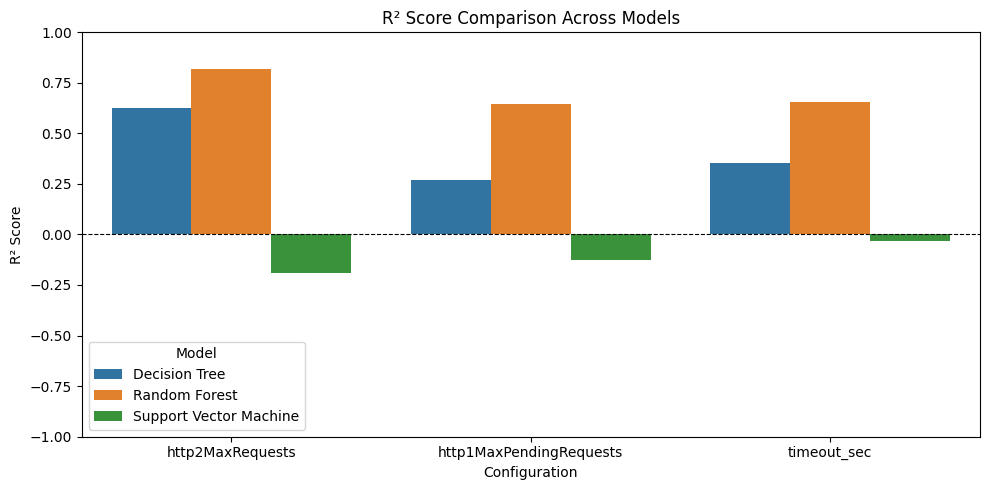

In [4]:
# Save R² comparison
plt.figure(figsize=(10, 5))
sns.barplot(data=performance_df, x="Configuration", y="R2", hue="Model")
plt.title("R² Score Comparison Across Models")
plt.ylabel("R² Score")
plt.ylim(-1, 1)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend(title="Model")
plt.tight_layout()
plt.show()


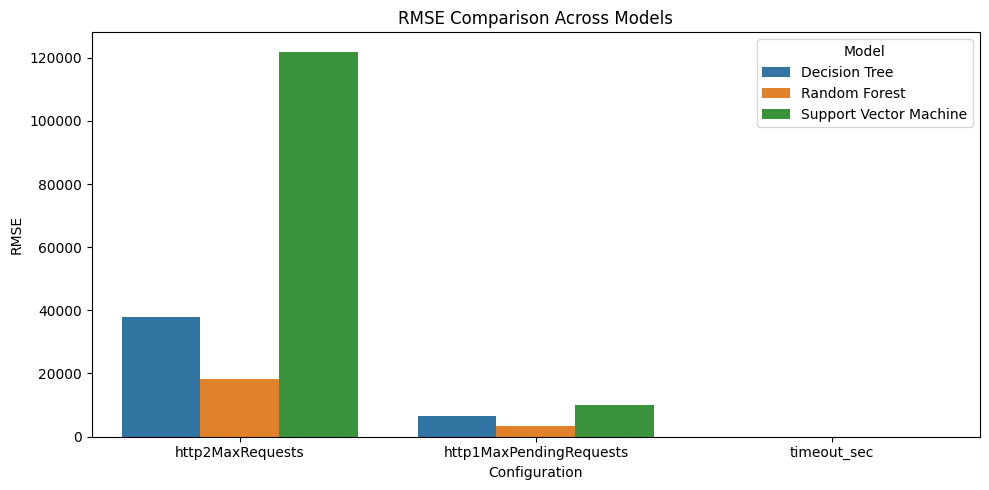

In [11]:

# Save RMSE comparison
plt.figure(figsize=(10, 5))
sns.barplot(data=performance_df, x="Configuration", y="RMSE", hue="Model")
plt.title("RMSE Comparison Across Models")
plt.ylabel("RMSE")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

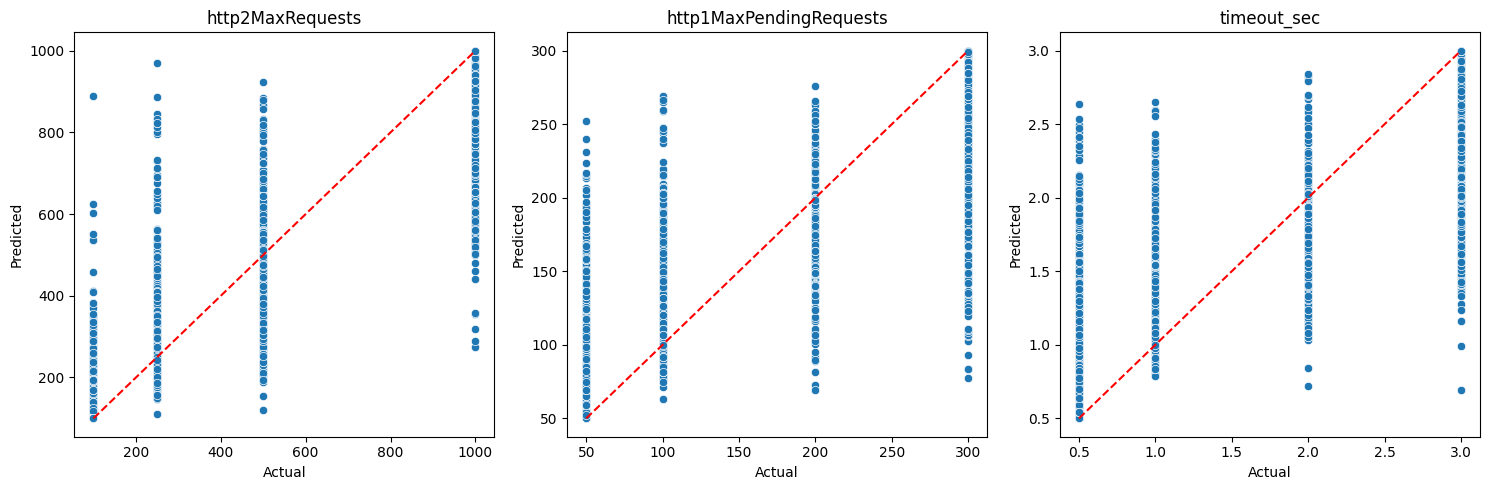

In [10]:
# Extra: Random Forest Predictions & Residuals
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)
Y_pred = rf_model.predict(X_test)

# Convert predictions and actuals to DataFrame
pred_df = pd.DataFrame(Y_pred, columns=Y_test.columns)
actual_df = Y_test.reset_index(drop=True)
residuals = actual_df - pred_df
residuals.columns = [col + "_residual" for col in residuals.columns]

# Save Prediction vs Actual
plt.figure(figsize=(15, 5))
for i, col in enumerate(actual_df.columns):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(x=actual_df[col], y=pred_df[col])
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(col)
    plt.plot([actual_df[col].min(), actual_df[col].max()],
             [actual_df[col].min(), actual_df[col].max()],
             'r--')
plt.tight_layout()
plt.show()


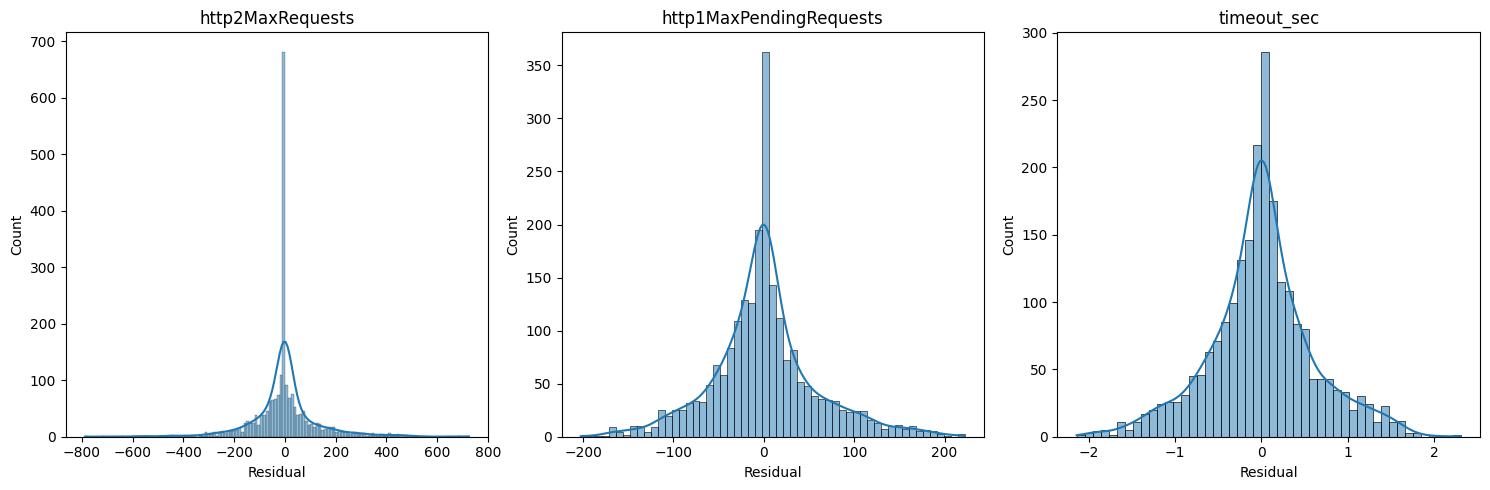

In [12]:

# Save Residual Distributions
plt.figure(figsize=(15, 5))
for i, col in enumerate(residuals.columns):
    plt.subplot(1, 3, i+1)
    sns.histplot(residuals[col], kde=True)
    plt.title(col.replace("_residual", ""))
    plt.xlabel("Residual")
plt.tight_layout()
plt.show()